In [20]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import models
import pandas as pd
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

In [21]:
class VGG1Block(nn.Module):
    def __init__(self):
        super(VGG1Block, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 100 * 100, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

class VGG3Block(nn.Module):
  def __init__(self):
    super(VGG3Block,self).__init__()
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
    )
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # Changed in_channels to 32
        nn.ReLU(),
    )
    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv_layer3 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # Changed in_channels to 64
        nn.ReLU(),
    )
    self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.flatten = nn.Flatten()
    self.fc_layers = nn.Sequential(
        nn.Linear(128 * 25 * 25, 128),  # Adjusted the flattened size
        nn.ReLU(),
        nn.Linear(128, 1),
    )

  def forward(self, x):
      x = self.conv_layer1(x)
      x = self.maxpool1(x)
      x = self.conv_layer2(x)
      x = self.maxpool2(x)
      x = self.conv_layer3(x)
      x = self.maxpool3(x)
      x = self.flatten(x)
      x = self.fc_layers(x)
      return x


class TransferLearningAllLayers(nn.Module):
    def __init__(self):
        super(TransferLearningAllLayers, self).__init__()
        self.base_model = models.vgg16(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Linear(1000, 128),  # Adjust input features to match your final conv layer output
            nn.ReLU(inplace=True),
            nn.Linear(128, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x

class TransferLearningFinalMLP(nn.Module):
    def __init__(self):
        super(TransferLearningFinalMLP, self).__init__()
        self.base_model = models.vgg16(pretrained=True)
        for param in self.base_model.parameters():
            param.requires_grad = False  # Freeze convolution layers
        self.classifier = nn.Sequential(
            nn.Linear(1000, 128),  # Adjust input features to match your final conv layer output
            nn.ReLU(inplace=True),
            nn.Linear(128, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 1)
        )  # Change final layer to match output classes

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x


In [31]:
model_vgg1block = VGG1Block()
model_vgg1block.load_state_dict(torch.load("/Users/na/Machine Learning Assignment/Assignment-4/models/0.pth"))

model_vgg3block = VGG3Block()
model_vgg3block.load_state_dict(torch.load("/Users/na/Machine Learning Assignment/Assignment-4/models/1.pth"))

model_vgg3block_a = VGG3Block()
model_vgg3block_a.load_state_dict(torch.load("/Users/na/Machine Learning Assignment/Assignment-4/models/3.pth"))

model_TransferLearningAllLayers = TransferLearningAllLayers()
model_TransferLearningAllLayers.load_state_dict(torch.load("/Users/na/Machine Learning Assignment/Assignment-4/models/4.pth"))

model_TransferLearningFinalMLP = TransferLearningFinalMLP()
model_TransferLearningFinalMLP.load_state_dict(torch.load("/Users/na/Machine Learning Assignment/Assignment-4/models/5.pth"))

/var/folders/kn/9gqwdgkj59zg8_vc_s8h33200000gn/T/ipykernel_14114/1252060221.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vgg1block.load_state_dict(torch.load("/

<All keys matched successfully>

In [32]:
import torch

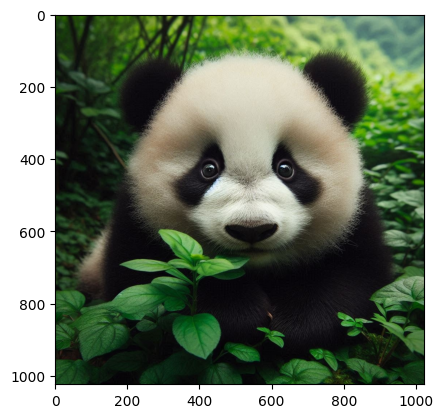

Classification by VGG1Block: PANDA
Classification by VGG3Block: RAT
Classification by VGG3Block trained on augmented data: RAT
Classification by Transfer learning on all layers of VGG1Block: RAT
Classification by Transfer learning on only MLP layer of VGG1Block: PANDA


In [124]:
import torch
from skimage import io
import matplotlib.pyplot as plt

# Load and display the image
image1 = io.imread("/Users/na/Machine Learning Assignment/Assignment-4/AI_gen_images/p_e.jpeg")
plt.imshow(image1)
plt.show()

# Convert the image to a PyTorch tensor
image1 = torch.tensor(image1, dtype=torch.float32)

image1 = image1.permute(2, 0, 1).unsqueeze(0)
resize = nn.AdaptiveAvgPool3d([3,200,200])
image1 = resize(image1)

l1 = "RAT" if model_vgg1block(image1) > 0 else "PANDA"
# l1 = "RAT" if model_vgg1block(image1) > 0 else "PANDA"

l4 = "RAT" if model_TransferLearningAllLayers(image1)> 0 else "PANDA"
# l4 = "RAT" if model_TransferLearningAllLayers(image1)> 0 else "PANDA"
l5 = "RAT" if model_TransferLearningFinalMLP(image1)> 0 else "PANDA"

# l1 = "RAT" if model_vgg1block(image1) > 0 else "PANDA"
# l2 = "RAT" if model_vgg3block(image1) > 0 else "PANDA"
#
#

l2 = "RAT" if model_vgg3block(image1) > 0 else "PANDA"
#
#

l3 = "RAT" if model_vgg3block_a(image1) > 0 else "PANDA"


print("Classification by VGG1Block:", l1)
print("Classification by VGG3Block:", l2)
print("Classification by VGG3Block trained on augmented data:", l3)
print("Classification by Transfer learning on all layers of VGG1Block:", l4)
print("Classification by Transfer learning on only MLP layer of VGG1Block:", l5)


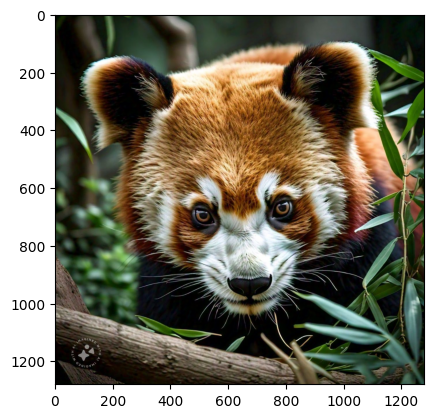

Classification by VGG1Block: RAT
Classification by VGG3Block: RAT
Classification by VGG3Block trained on augmented data: RAT
Classification by Transfer learning on all layers of VGG1Block: PANDA
Classification by Transfer learning on only MLP layer of VGG1Block: PANDA


In [106]:
# Load and display the image
image1 = io.imread("/Users/na/Machine Learning Assignment/Assignment-4/AI_gen_images/p_h.jpeg")
plt.imshow(image1)
plt.show()

# Convert the image to a PyTorch tensor
image1 = torch.tensor(image1, dtype=torch.float32)

image1 = image1.permute(2, 0, 1).unsqueeze(0)
resize = nn.AdaptiveAvgPool3d([3,200,200])
image1 = resize(image1)

l1 = "RAT" if model_vgg1block(image1) > 0 else "PANDA"
l2 = "RAT" if model_vgg3block(image1) > 0 else "PANDA"

# l1 = "RAT" if model_vgg1block(image1) > 0 else "PANDA"
# l2 = "RAT" if model_vgg3block(image1) > 0 else "PANDA"
#
#

l3 = "RAT" if model_vgg3block_a(image1) > 0 else "PANDA"
l4 = "RAT" if model_TransferLearningAllLayers(image1)>0 else "PANDA"
l5 = "RAT" if model_TransferLearningFinalMLP(image1)>0 else "PANDA"

print("Classification by VGG1Block:", l1)
print("Classification by VGG3Block:", l2)
print("Classification by VGG3Block trained on augmented data:", l3)
print("Classification by Transfer learning on all layers of VGG1Block:", l4)
print("Classification by Transfer learning on only MLP layer of VGG1Block:", l5)

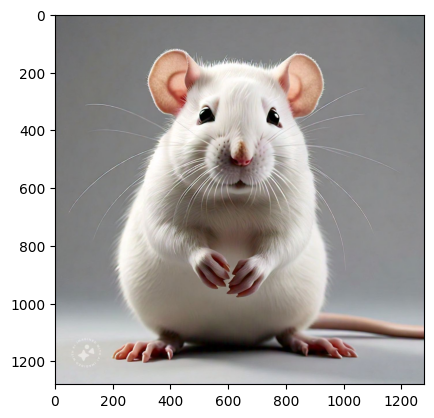

Classification by VGG1Block: RAT
Classification by VGG3Block: RAT
Classification by VGG3Block trained on augmented data: RAT
Classification by Transfer learning on all layers of VGG1Block: RAT
Classification by Transfer learning on only MLP layer of VGG1Block: RAT


In [86]:
# Load and display the image
image1 = io.imread("/Users/na/Machine Learning Assignment/Assignment-4/AI_gen_images/r_e.jpeg")
plt.imshow(image1)
plt.show()

# Convert the image to a PyTorch tensor
image1 = torch.tensor(image1, dtype=torch.float32)

image1 = image1.permute(2, 0, 1).unsqueeze(0)
resize = nn.AdaptiveAvgPool3d([3,200,200])
image1 = resize(image1)

l1 = "RAT" if model_vgg1block(image1) > 0 else "PANDA"
l2 = "RAT" if model_vgg3block(image1) > 0 else "PANDA"
l3 = "RAT" if model_vgg3block_a(image1) > 0 else "PANDA"
l4 = "RAT" if model_TransferLearningAllLayers(image1)> 0 else "PANDA"
l5 = "RAT" if model_TransferLearningFinalMLP(image1)> 0 else "PANDA"

print("Classification by VGG1Block:", l1)
print("Classification by VGG3Block:", l2)
print("Classification by VGG3Block trained on augmented data:", l3)
print("Classification by Transfer learning on all layers of VGG1Block:", l4)
print("Classification by Transfer learning on only MLP layer of VGG1Block:", l5)

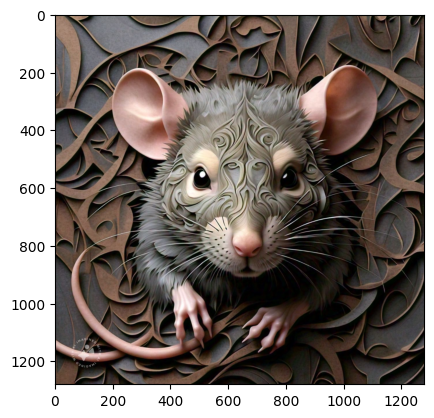

Classification by VGG1Block: RAT
Classification by VGG3Block: RAT
Classification by VGG3Block trained on augmented data: RAT
Classification by Transfer learning on all layers of VGG1Block: RAT
Classification by Transfer learning on only MLP layer of VGG1Block: RAT


In [101]:
# Load and display the image
image1 = io.imread("/Users/na/Machine Learning Assignment/Assignment-4/AI_gen_images/r_h.jpeg")
plt.imshow(image1)
plt.show()

# Convert the image to a PyTorch tensor
image1 = torch.tensor(image1, dtype=torch.float32)

image1 = image1.permute(2, 0, 1).unsqueeze(0)
resize = nn.AdaptiveAvgPool3d([3,200,200])
image1 = resize(image1)

l1 = "RAT" if model_vgg1block(image1) > 0 else "PANDA"
l2 = "RAT" if model_vgg3block(image1) > 0 else "PANDA"
l3 = "RAT" if model_vgg3block_a(image1) > 0 else "PANDA"
l4 = "RAT" if model_TransferLearningAllLayers(image1)> 0 else "PANDA"
l5 = "RAT" if model_TransferLearningFinalMLP(image1)> 0 else "PANDA"

print("Classification by VGG1Block:", l1)
print("Classification by VGG3Block:", l2)
print("Classification by VGG3Block trained on augmented data:", l3)
print("Classification by Transfer learning on all layers of VGG1Block:", l4)
print("Classification by Transfer learning on only MLP layer of VGG1Block:", l5)